In [1]:
import os
import copy
import torch
import itertools
import matplotlib.pyplot as plt
import numpy as np
os.chdir('..')

/home/xumingjie/miniconda3/envs/open-mmlab/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import cv2
import mmcv
import numpy as np
from mmcv import Config, DictAction, ProgressBar

from mmselfsup.datasets.builder import PIPELINES, build_dataset, build_from_cfg

In [3]:
PHASE = 'train' # train / val / test

In [4]:
def build_dataset_pipelines(cfg, phase):
    """build dataset and pipeline from config.
    Separate the pipeline except 'LoadImageFromFile' step if
    'LoadImageFromFile' in the pipeline.
    """
    data_cfg = cfg.data[phase]
    loadimage_pipeline = []
    origin_pipelines = data_cfg.pipelines
    data_cfg.pipelines = [[] for i in range(len(origin_pipelines))]
    dataset = build_dataset(data_cfg)
    multi_pipelines = []
    for origin_pipeline in origin_pipelines:
        pipelines = {
            pipeline_cfg['type']: build_from_cfg(pipeline_cfg, PIPELINES)
            for pipeline_cfg in origin_pipeline
        }
        multi_pipelines.append(pipelines)

    return dataset, multi_pipelines

### Model configs

In [5]:
# Load the basic config file
from mmcv import Config
cfg = Config.fromfile('configs/selfsup/breast_pred/ddsm_breast_config.py')

# Specify the data settings
cfg.data.samples_per_gpu = 1
cfg.data.workers_per_gpu = 1

# Modify the path and meta files of train dataset
cfg.data.train.data_source.data_prefix = '/home/xumingjie/Desktop/ddsm_breast/ddsm_breast'
cfg.data.train.data_source.ann_file = '/home/xumingjie/Desktop/ddsm_breast/seq_lv_train_set.csv'

# Specify the work directory
cfg.work_dir = 'logs/ddsm_breast_mocov3'

# Set the random seed and enable the deterministic option of cuDNN
# to keep the results' reproducible.
from mmselfsup.apis import set_random_seed
cfg.seed = 0
set_random_seed(0, deterministic=True)

cfg.gpu_ids = range(1)

dataset, multi_pipelines = build_dataset_pipelines(cfg, PHASE)
views = ['CC', 'MLO']
display_number = 5
wind_h,wind_w = (800,600)
progressBar = ProgressBar(display_number)
total_pip_images = []

for i, item in enumerate(itertools.islice(dataset, display_number)):
    # get intermediate images through pipelines    
    total_pips = []
    for idx, pipelines in enumerate(multi_pipelines):
        view = item['img'][idx]
        pipeline_images = [view.copy()]
        for pipeline in pipelines.values():
            view = pipeline(view)
            trans_img = copy.deepcopy(view)
            pipeline_images.append(trans_img)

        total_pips.append(pipeline_images)
    total_pip_images.append(total_pips)


[                                                  ] 0/5, elapsed: 0s, ETA:

/home/xumingjie/miniconda3/envs/open-mmlab/lib/python3.10/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


### Plot pipeline outputs for CC view

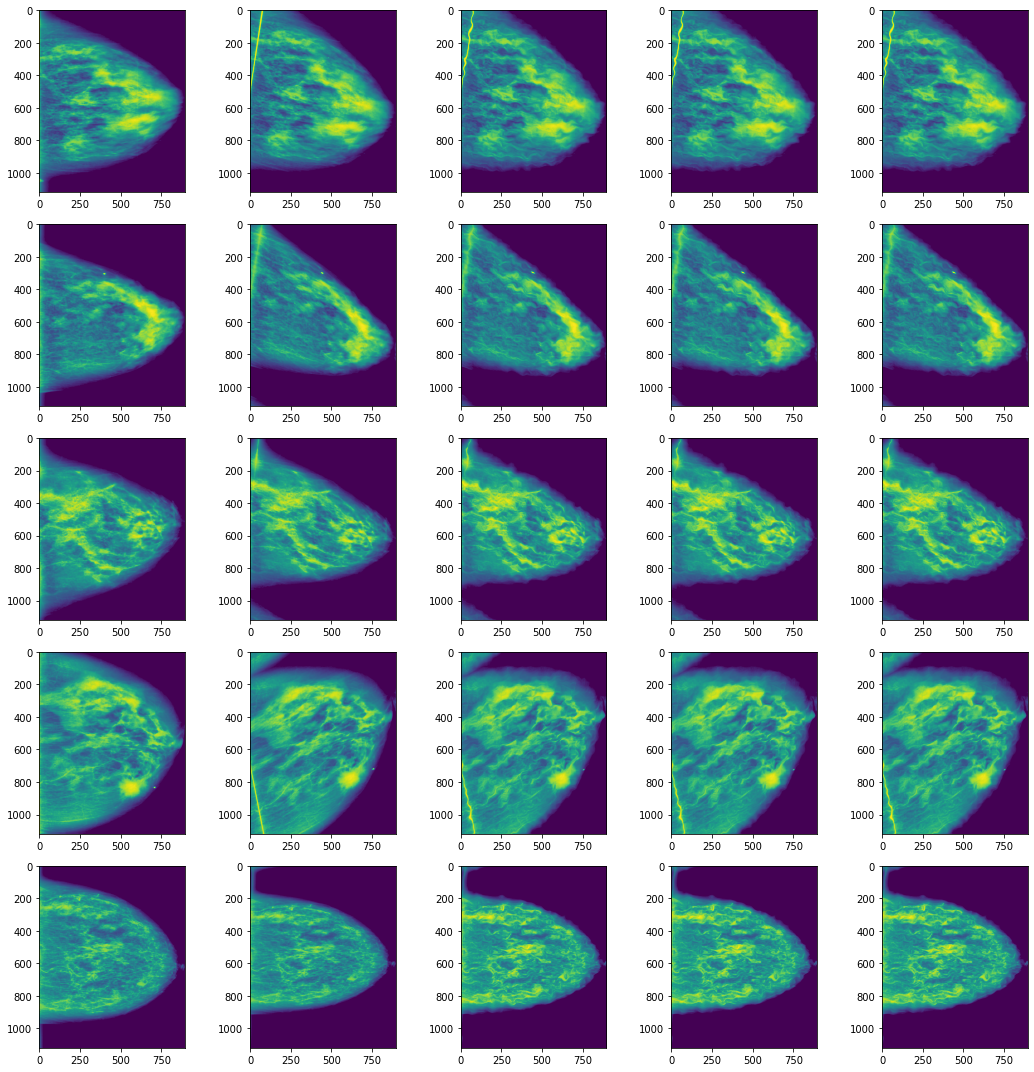

In [7]:
fig, axs = plt.subplots(len(total_pip_images), len(multi_pipelines[0])+1,figsize=(15,15))
for y in range(len(total_pip_images)):
    for x in range(len(multi_pipelines[0])+1):
        img = total_pip_images[y][0][x][0]
        if torch.is_tensor(img):
            img = img.numpy()
        axs[y,x].imshow(img)
fig.tight_layout()

### Plot pipeline outputs for MLO view

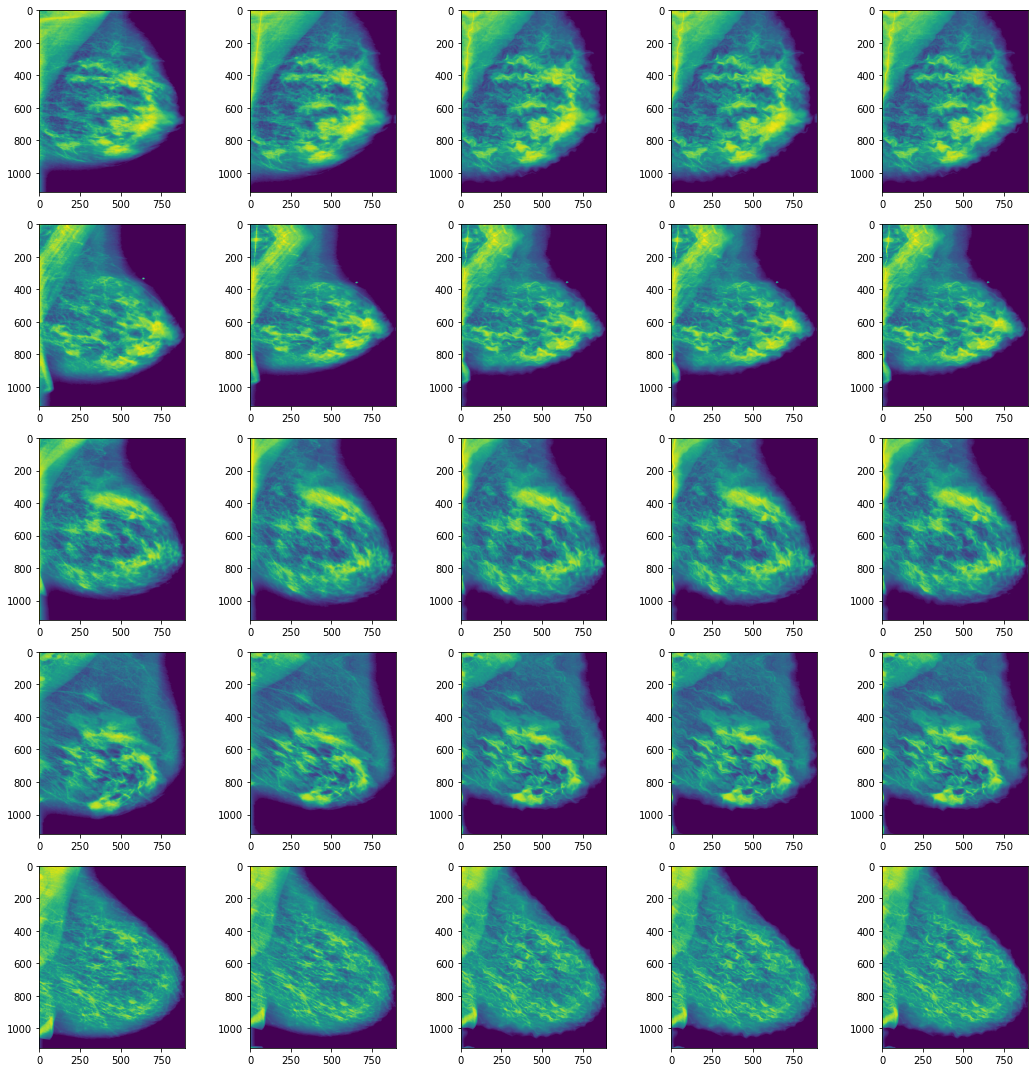

In [8]:
fig, axs = plt.subplots(len(total_pip_images), len(multi_pipelines[1])+1,figsize=(15,15))
for y in range(len(total_pip_images)):
    for x in range(len(multi_pipelines[1])+1):
        img = total_pip_images[y][1][x][0]
        if type(img) == torch.Tensor():
            img = img.numpy()
        axs[y,x].imshow(total_pip_images[y][1][x][0])
fig.tight_layout()